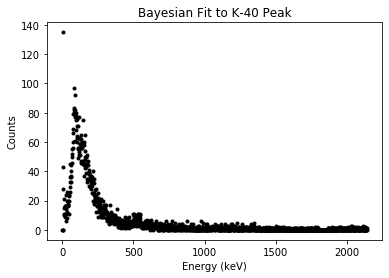

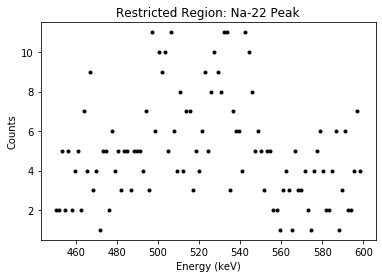

In [151]:
import numpy as np                                
import matplotlib.pyplot as plt
from scipy import optimize 
from scipy.stats import poisson, uniform
from scipy.signal import find_peaks

data_file = 'na22.txt'

#Na-22
xdata, ydata  = np.loadtxt(                 
        data_file,
        delimiter = '\t', 
        skiprows = 1,
        usecols = (0, 1),  
        unpack = True) 

# Calibration Factor:
# 15.116899662798184 +- 0.9251446612961983
# Determined from Gamma Spec.
xdata = xdata * 15.116899662798

plt.errorbar(xdata, ydata, fmt='k.')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('Bayesian Fit to K-40 Peak')
plt.show()

# Restrict data to Na-22 Region of Interest (around 511keV)
na22_min, na22_max = 450, 600 
roi_mask = (xdata >= na22_min) & (xdata <= na22_max)
xdata_na22 = xdata[roi_mask]
ydata_na22 = ydata[roi_mask]

# Plot the restricted ROI
plt.errorbar(xdata_na22, ydata_na22, fmt='k.')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('Restricted Region: Na-22 Peak')
plt.show()

In [152]:
# Normalized Lorentzian 
def func(E, A, E_0, Gamma, B):
    peak = A / (((E - E_0)**2) + (Gamma**2 / 4))
    return peak + B

# Poisson likelihood
def log_likelihood(params, xdata, ydata):
    A, E_0, Gamma, B = params
    expected_counts = func(xdata, A, E_0, Gamma, B)
    return np.sum(poisson.logpmf(ydata, expected_counts))

# Priors

# Updated Priors for Na-22 Peak
def log_prior(params):
    A, E_0, Gamma, B = params
    if (0 <= A <= 20 and
        450 <= E_0 <= 600 and  # Na-22 energy range
        0 <= Gamma <= 5 and  # Reasonable peak width
        0 <= B <= 30):  # Background limited by ROI baseline
        return 0  # Uniform prior
    return -np.inf  # Log-prior of 0 for invalid values

# Posterior
def log_posterior(params, xdata, ydata):
    return log_prior(params) + log_likelihood(params, xdata, ydata)

# MCMC with adaptive step sizes
def metropolis_hastings_adaptive(log_posterior, initial_params, n_samples, step_sizes, xdata, ydata, adapt_rate=0.05):
    params = np.array(initial_params)
    samples = []
    current_log_post = log_posterior(params, xdata, ydata)
    acceptance = np.zeros(len(params))

    for i in range(n_samples):
        proposal = params + np.random.normal(0, step_sizes, size=len(params))
        proposed_log_post = log_posterior(proposal, xdata, ydata)

        if np.log(np.random.rand()) < proposed_log_post - current_log_post:
            params = proposal
            current_log_post = proposed_log_post
            acceptance += 1

        samples.append(params)

        if i > 0 and i % 100 == 0:
            acceptance_rate = acceptance / 100
            step_sizes = step_sizes * (1 + adapt_rate * (acceptance_rate - 0.25))
            acceptance[:] = 0

    return np.array(samples), step_sizes

Final step sizes: [0.141405   7.07025019 0.0141405  0.141405  ]


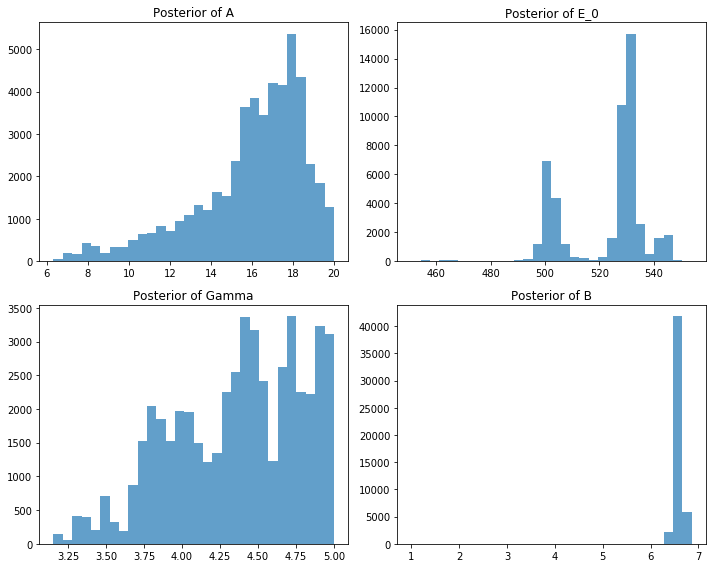

Best-fit Parameters: A = 15.98, E_0 = 522.51 keV, Gamma = 4.36, B = 6.57


In [153]:
# Initial Parameters and Run MCMC
initial_params = [A_initial, estimated_E_0, Gamma_initial, B_initial]

n_samples = 50_000
step_sizes = [0.1, 5, 0.01, 0.1]  # Start with 0.1

samples, final_step_sizes = metropolis_hastings_adaptive(
    log_posterior, initial_params, n_samples, step_sizes, xdata, ydata
)
print(f"Final step sizes: {final_step_sizes}")

# Analyze Posterior
param_names = ['A', 'E_0', 'Gamma', 'B']
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, ax in enumerate(axs.flatten()):
    ax.hist(samples[:, i], bins=30, alpha=0.7, label=param_names[i])
    ax.set_title(f'Posterior of {param_names[i]}')
    
plt.tight_layout()
plt.show()

# Best-fit Parameters
best_params = samples.mean(axis=0)
print(f"Best-fit Parameters: A = {best_params[0]:.2f}, E_0 = {best_params[1]:.2f} keV, Gamma = {best_params[2]:.2f}, B = {best_params[3]:.2f}")

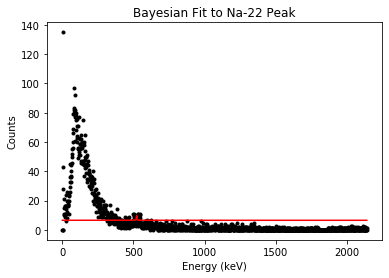

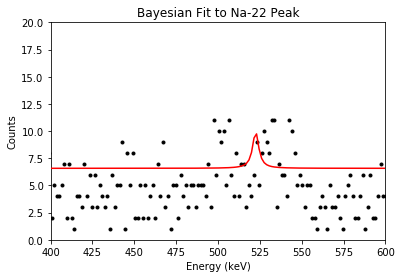

In [154]:
best_params = samples.mean(axis=0)

# Plot best fit
plt.plot(xdata, func(xdata, *best_params), color='red', label='Best Fit', zorder=3)  # Plot best fit line with higher z-order
plt.errorbar(xdata, ydata, fmt='k.', label='Observed Data', zorder=2)  # Plot data points with lower z-order
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('Bayesian Fit to Na-22 Peak')
#plt.legend()
plt.show()

plt.plot(xdata, func(xdata, *best_params), color='red', label='Best Fit', zorder=3)
plt.errorbar(xdata, ydata, fmt='k.', label='Observed Data', zorder=2)
plt.xlim(400, 600)  # Zoom in on the ROI for Na-22
plt.ylim(0, 20)  # Adjust y-limits for clarity
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('Bayesian Fit to Na-22 Peak')
#plt.legend()
plt.show()

In [155]:
# peak_probability = np.mean((samples[:, 1] >= 450) & (samples[:, 1] <= 600))
# print(f"Probability that the peak energy lies within 450-600 keV: {peak_probability:.3f}")
# peak_probability = np.mean((samples[:, 1] >= 1500) & (samples[:, 1] <= 1515))
# print(f"Probability that the peak energy lies within 1500-1515 keV: {peak_probability:.3f}")

probability_ranges = []

for i in range(300):
    start_index = 300 + i
    end_index =  start_index + 1
    peak_probability = np.mean((samples[:, 1] >= start_index) & (samples[:, 1] <= end_index))
    
    if np.equal(peak_probability, 0):
        continue

    dataset = (start_index, end_index, round(peak_probability*100,2))
    
    probability_ranges.append( dataset )

for i in probability_ranges:
    print(i)

max = 0
max_data = ()
for i in probability_ranges:
    if i[2]>max:
        max_data = i
        max = i[2]
print('\n',max_data, max,'%')

(450, 451, 0.01)
(451, 452, 0.02)
(452, 453, 0.03)
(453, 454, 0.03)
(454, 455, 0.04)
(455, 456, 0.02)
(456, 457, 0.05)
(457, 458, 0.03)
(458, 459, 0.02)
(459, 460, 0.02)
(460, 461, 0.04)
(461, 462, 0.06)
(462, 463, 0.03)
(463, 464, 0.02)
(464, 465, 0.05)
(465, 466, 0.06)
(466, 467, 0.07)
(467, 468, 0.04)
(468, 469, 0.02)
(469, 470, 0.01)
(470, 471, 0.03)
(471, 472, 0.02)
(472, 473, 0.02)
(473, 474, 0.02)
(474, 475, 0.03)
(475, 476, 0.02)
(476, 477, 0.02)
(477, 478, 0.03)
(478, 479, 0.02)
(479, 480, 0.01)
(480, 481, 0.01)
(481, 482, 0.04)
(482, 483, 0.0)
(483, 484, 0.02)
(484, 485, 0.02)
(485, 486, 0.03)
(486, 487, 0.02)
(487, 488, 0.02)
(488, 489, 0.03)
(489, 490, 0.03)
(490, 491, 0.04)
(491, 492, 0.06)
(492, 493, 0.04)
(493, 494, 0.04)
(494, 495, 0.15)
(495, 496, 0.16)
(496, 497, 0.34)
(497, 498, 0.89)
(498, 499, 1.36)
(499, 500, 2.62)
(500, 501, 3.85)
(501, 502, 5.14)
(502, 503, 4.8)
(503, 504, 2.97)
(504, 505, 1.86)
(505, 506, 1.42)
(506, 507, 1.11)
(507, 508, 0.59)
(508, 509, 0.3)


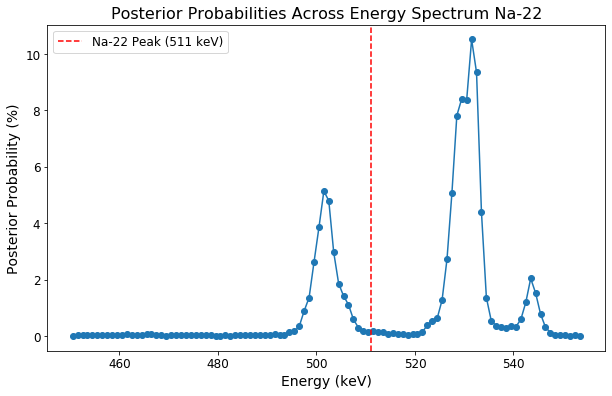

Significant Energy Ranges (Probability > 5%):
Energy Range: 501.0-502.0 keV, Probability: 5.14%
Energy Range: 527.0-528.0 keV, Probability: 5.07%
Energy Range: 528.0-529.0 keV, Probability: 7.82%
Energy Range: 529.0-530.0 keV, Probability: 8.42%
Energy Range: 530.0-531.0 keV, Probability: 8.38%
Energy Range: 531.0-532.0 keV, Probability: 10.52%
Energy Range: 532.0-533.0 keV, Probability: 9.35%


In [156]:
import numpy as np
import matplotlib.pyplot as plt

# Data: Energy ranges and probabilities
data_array = np.array(probability_ranges, dtype=[('start', float), ('end', float), ('probability', float)])

# Calculate range centers
centers = (data_array['start'] + data_array['end']) / 2

# Plot posterior probabilities
plt.figure(figsize=(10, 6))
plt.plot(centers, data_array['probability'], marker='o')
plt.axvline(x=511, color='red', linestyle='--', label='Na-22 Peak (511 keV)')
plt.title('Posterior Probabilities Across Energy Spectrum Na-22', fontsize=16)
plt.xlabel('Energy (keV)', fontsize=14)
plt.ylabel('Posterior Probability (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

# Identify significant probabilities
significant = data_array[data_array['probability'] > 5]

# Display significant energy ranges
print("Significant Energy Ranges (Probability > 5%):")
for row in significant:
    print(f"Energy Range: {row['start']}-{row['end']} keV, Probability: {row['probability']}%")

Final step sizes: [ 0.28916211 14.45810553  0.02891621  0.28916211]


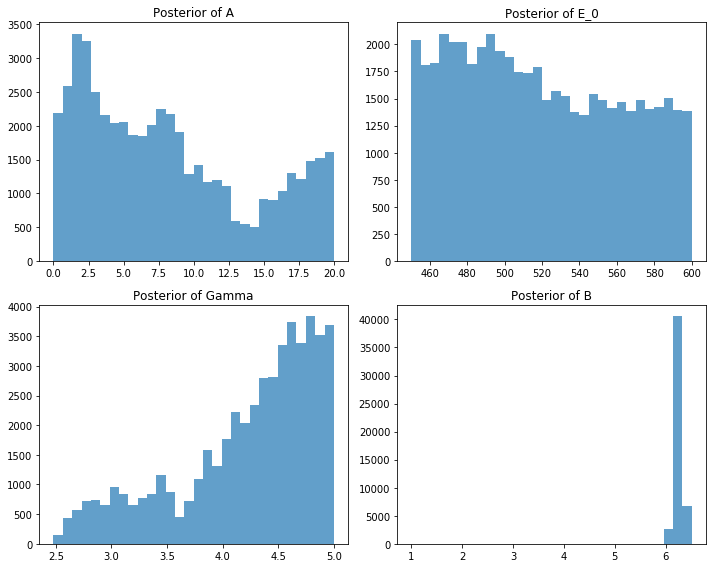

Best-fit Parameters: A = 8.13, E_0 = 519.33 keV, Gamma = 4.21, B = 6.24


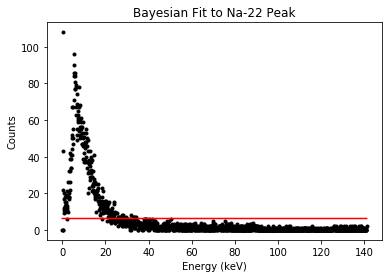

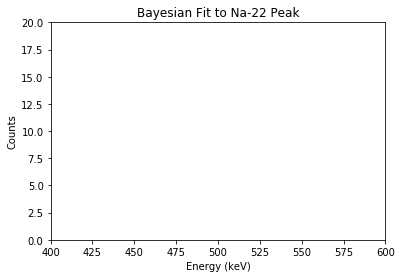

(450, 451, 0.69)
(451, 452, 0.83)
(452, 453, 0.74)
(453, 454, 0.94)
(454, 455, 0.8)
(455, 456, 0.77)
(456, 457, 0.69)
(457, 458, 0.76)
(458, 459, 0.78)
(459, 460, 0.67)
(460, 461, 0.8)
(461, 462, 0.74)
(462, 463, 0.68)
(463, 464, 0.61)
(464, 465, 0.79)
(465, 466, 0.96)
(466, 467, 0.91)
(467, 468, 0.59)
(468, 469, 0.95)
(469, 470, 0.79)
(470, 471, 0.77)
(471, 472, 0.82)
(472, 473, 0.85)
(473, 474, 0.76)
(474, 475, 0.85)
(475, 476, 0.81)
(476, 477, 0.81)
(477, 478, 0.74)
(478, 479, 0.81)
(479, 480, 0.89)
(480, 481, 0.66)
(481, 482, 0.79)
(482, 483, 0.75)
(483, 484, 0.79)
(484, 485, 0.63)
(485, 486, 0.65)
(486, 487, 0.76)
(487, 488, 0.75)
(488, 489, 0.89)
(489, 490, 0.92)
(490, 491, 0.81)
(491, 492, 0.82)
(492, 493, 0.99)
(493, 494, 0.76)
(494, 495, 0.81)
(495, 496, 0.85)
(496, 497, 0.7)
(497, 498, 0.77)
(498, 499, 0.88)
(499, 500, 0.69)
(500, 501, 0.73)
(501, 502, 0.87)
(502, 503, 0.66)
(503, 504, 0.7)
(504, 505, 0.8)
(505, 506, 0.71)
(506, 507, 0.62)
(507, 508, 0.71)
(508, 509, 0.7)
(50

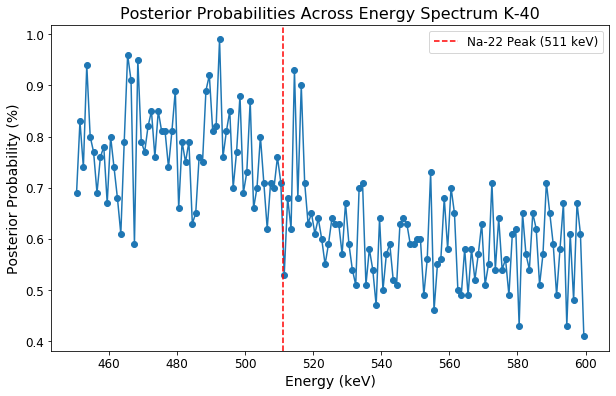

Significant Energy Ranges (Probability > 5%):


In [150]:
data_file = 'k40.txt'

#k40

#quick sanity check
xdata, ydata  = np.loadtxt(                 
        data_file,
        delimiter = '\t', 
        skiprows = 1,
        usecols = (0, 1),  
        unpack = True) 

# Initial Parameters and Run MCMC
initial_params = [A_initial, estimated_E_0, Gamma_initial, B_initial]

n_samples = 50_000
step_sizes = [0.1, 5, 0.01, 0.1]  # Start with 0.1

samples, final_step_sizes = metropolis_hastings_adaptive(
    log_posterior, initial_params, n_samples, step_sizes, xdata, ydata
)
print(f"Final step sizes: {final_step_sizes}")

# Analyze Posterior
param_names = ['A', 'E_0', 'Gamma', 'B']
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, ax in enumerate(axs.flatten()):
    ax.hist(samples[:, i], bins=30, alpha=0.7, label=param_names[i])
    ax.set_title(f'Posterior of {param_names[i]}')
    
plt.tight_layout()
plt.show()

# Best-fit Parameters
best_params = samples.mean(axis=0)
print(f"Best-fit Parameters: A = {best_params[0]:.2f}, E_0 = {best_params[1]:.2f} keV, Gamma = {best_params[2]:.2f}, B = {best_params[3]:.2f}")

best_params = samples.mean(axis=0)

# Plot best fit
plt.plot(xdata, func(xdata, *best_params), color='red', label='Best Fit', zorder=3)  # Plot best fit line with higher z-order
plt.errorbar(xdata, ydata, fmt='k.', label='Observed Data', zorder=2)  # Plot data points with lower z-order
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('Bayesian Fit to Na-22 Peak')
#plt.legend()
plt.show()

plt.plot(xdata, func(xdata, *best_params), color='red', label='Best Fit', zorder=3)
plt.errorbar(xdata, ydata, fmt='k.', label='Observed Data', zorder=2)
plt.xlim(400, 600)  # Zoom in on the ROI for Na-22
plt.ylim(0, 20)  # Adjust y-limits for clarity
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('Bayesian Fit to Na-22 Peak')
#plt.legend()
plt.show()

# peak_probability = np.mean((samples[:, 1] >= 450) & (samples[:, 1] <= 600))
# print(f"Probability that the peak energy lies within 450-600 keV: {peak_probability:.3f}")
# peak_probability = np.mean((samples[:, 1] >= 1500) & (samples[:, 1] <= 1515))
# print(f"Probability that the peak energy lies within 1500-1515 keV: {peak_probability:.3f}")

probability_ranges = []

for i in range(300):
    start_index = 300 + i
    end_index =  start_index + 1
    peak_probability = np.mean((samples[:, 1] >= start_index) & (samples[:, 1] <= end_index))
    
    if np.equal(peak_probability, 0):
        continue

    dataset = (start_index, end_index, round(peak_probability*100,2))
    
    probability_ranges.append( dataset )

for i in probability_ranges:
    print(i)

max = 0
max_data = ()
for i in probability_ranges:
    if i[2]>max:
        max_data = i
        max = i[2]
print('\n',max_data, max,'%')

import numpy as np
import matplotlib.pyplot as plt

# Data: Energy ranges and probabilities
data_array = np.array(probability_ranges, dtype=[('start', float), ('end', float), ('probability', float)])

# Calculate range centers
centers = (data_array['start'] + data_array['end']) / 2

# Plot posterior probabilities

plt.figure(figsize=(10, 6))
plt.plot(centers, data_array['probability'], marker='o')
plt.axvline(x=511, color='red', linestyle='--', label='Na-22 Peak (511 keV)')
plt.title('Posterior Probabilities Across Energy Spectrum K-40', fontsize=16)
plt.xlabel('Energy (keV)', fontsize=14)
plt.ylabel('Posterior Probability (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

# Identify significant probabilities
significant = data_array[data_array['probability'] > 5]

# Display significant energy ranges
print("Significant Energy Ranges (Probability > 5%):")
for row in significant:
    print(f"Energy Range: {row['start']}-{row['end']} keV, Probability: {row['probability']}%")